I submitted this notebook for the in-house competition of the course "Data Mining Models and Algorithms" of the training "Mathematical Expert in Data Analysis and Machine Learning". I finished in 1st place based on pre-defined metric (balanced accuracy) that was evaluated on a separated unseen test set. The only rule was that we had to train a Random Forest classifier.

In [39]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
pd.pandas.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, classification_report, brier_score_loss, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedShuffleSplit, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.pipeline import Pipeline as imbalanced_Pipeline
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, DiscriminationThreshold, ClassPredictionError, ROCAUC
import optuna

In [3]:
train_df = pd.read_csv('ticdata2000.txt', sep='\t', header=None)
test_df = pd.read_csv('ticeval2000.txt', sep='\t', header=None)

column_names = []
fileobj = open("column names.txt", "r")
for line in fileobj:
    column_names.append(line.strip().split(":")[0])
fileobj.close()

train_df.columns = column_names

column_names.remove('CARAVAN')
test_df.columns = column_names

df = pd.concat([train_df, test_df]).reset_index(drop=True)

# EDA

## Essential observations

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9822 entries, 0 to 9821
Data columns (total 86 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MOSTYPE   9822 non-null   int64  
 1   MAANTHUI  9822 non-null   int64  
 2   MGEMOMV   9822 non-null   int64  
 3   MGEMLEEF  9822 non-null   int64  
 4   MOSHOOFD  9822 non-null   int64  
 5   MGODRK    9822 non-null   int64  
 6   MGODPR    9822 non-null   int64  
 7   MGODOV    9822 non-null   int64  
 8   MGODGE    9822 non-null   int64  
 9   MRELGE    9822 non-null   int64  
 10  MRELSA    9822 non-null   int64  
 11  MRELOV    9822 non-null   int64  
 12  MFALLEEN  9822 non-null   int64  
 13  MFGEKIND  9822 non-null   int64  
 14  MFWEKIND  9822 non-null   int64  
 15  MOPLHOOG  9822 non-null   int64  
 16  MOPLMIDD  9822 non-null   int64  
 17  MOPLLAAG  9822 non-null   int64  
 18  MBERHOOG  9822 non-null   int64  
 19  MBERZELF  9822 non-null   int64  
 20  MBERBOER  9822 non-null   int6

No missing values.

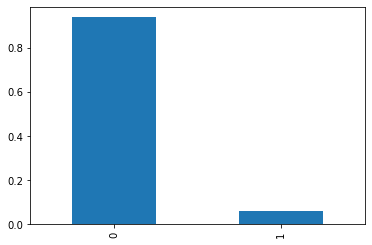

In [6]:
train_df['CARAVAN'].value_counts(normalize=True).plot(kind='bar')
plt.show()

Imbalanced dataset.

In [5]:
print(len(train_df[train_df.duplicated()]))
print(len(test_df[test_df.duplicated()]))
print(len(train_df[train_df.duplicated()])/len(train_df))
print(len(test_df[test_df.duplicated()])/len(test_df))

602
307
0.10340089316386121
0.07675


My understanding is that it would be a mistake if we would drop these duplicates since these are sociodemographic datas and it is natural that we have duplicates (based on the description). Moreover it is actually meaningful in my opinion if some observations appeared more. The ratio is pretty much the same, although maybe some postal codes are overrepresented in the train set or I don't know why this happened. Nevertheless in this analysis I won't deal with this issue.<br>Maybe if we have more time it worths a try to obtain the 'unique' duplicates in both datasets in dictionaries with the corresponding occurrences and analyze them. Also for me it is not simple how to obtain unique keys in the dictionaries based on the values of the feature vectors. In addition it just came to my mind that maybe the occurrences of each row could have been a good new feature, maybe it would have been meaningful for the model.

## Distributions

In [4]:
L3 = column_names[5:43]
L4 = column_names[43:]
the_rest = ['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD']

I won't include these plots (Seaborn countplot with hue=CARAVAN) and pandas queries but I obtained that the distribution of the response variable is pretty much the same in each enumeration in every variable. (Around 3-10%)

In [6]:
def compare_plot(train_df, test_df, variable):
    # train df distribution
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_df[variable].value_counts(normalize=True, ascending=True).sort_index(ascending=True).plot(kind='bar')
    plt.axhline(y=0.01, color="red")
    plt.xlabel(variable)
    plt.ylabel('Count')
    # test df distribution
    plt.subplot(1, 2, 2)
    test_df[variable].value_counts(normalize=True, ascending=True).sort_index(ascending=True).plot(kind='bar')
    plt.axhline(y=0.01, color="red")
    plt.xlabel(variable)
    plt.ylabel('Count')
    plt.show()

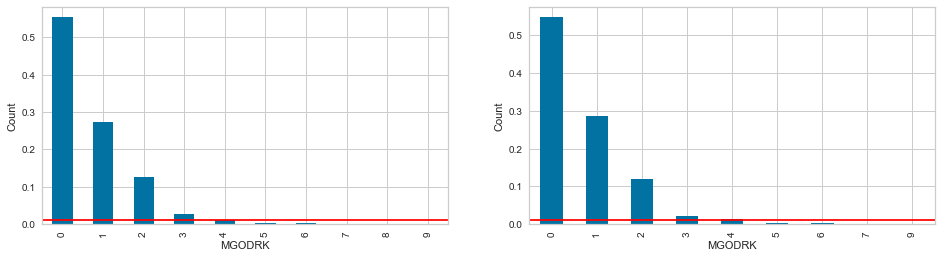

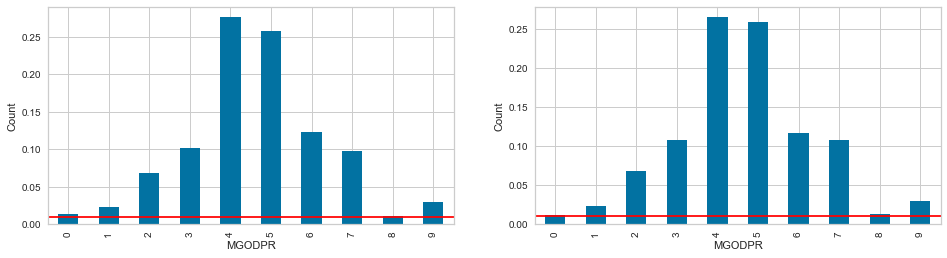

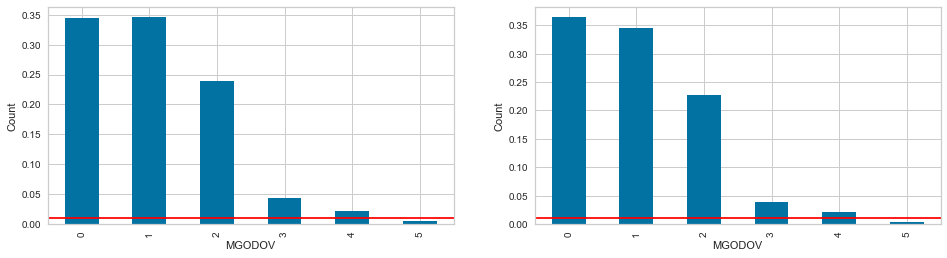

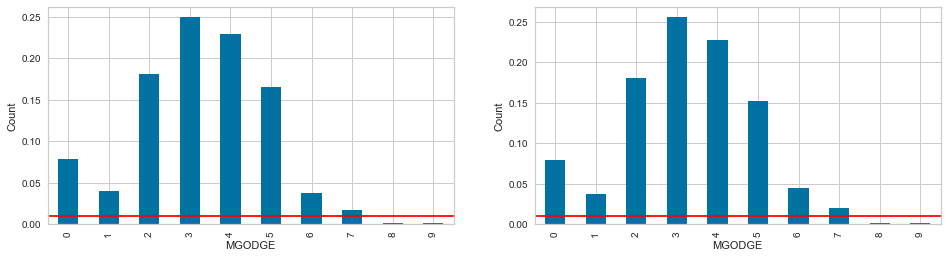

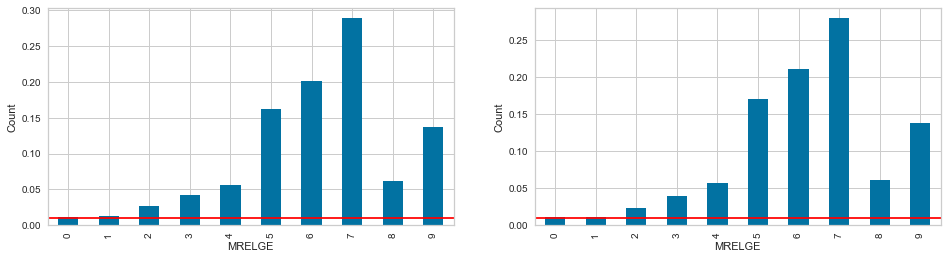

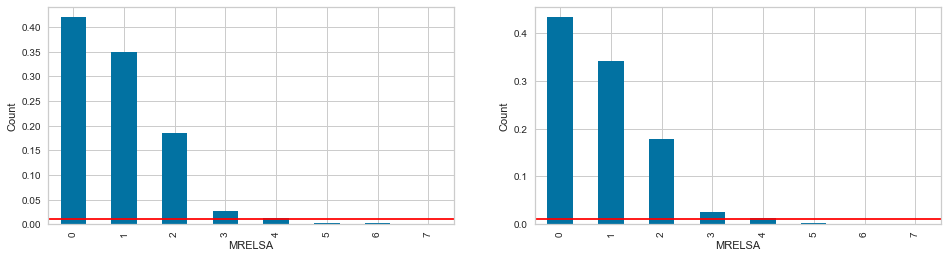

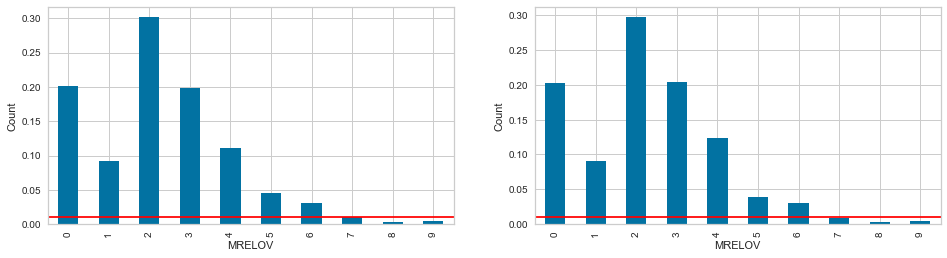

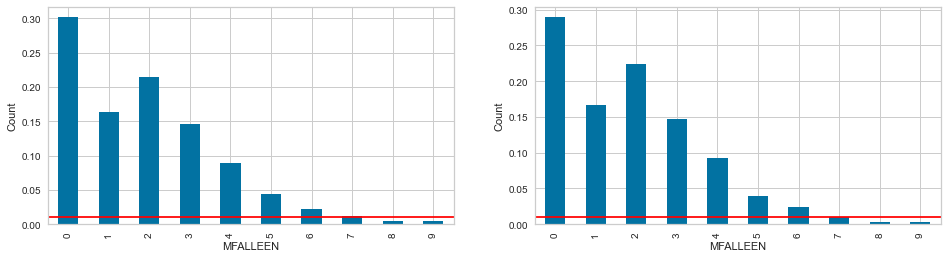

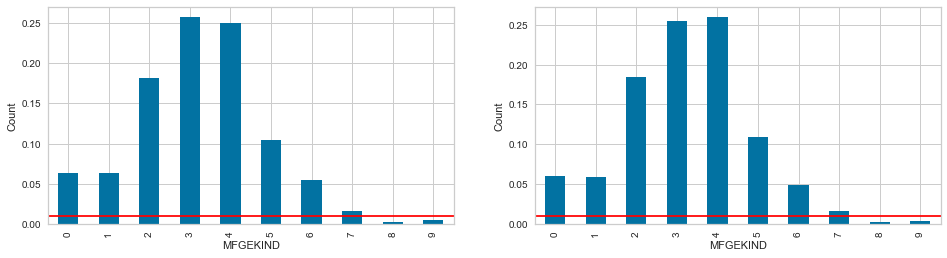

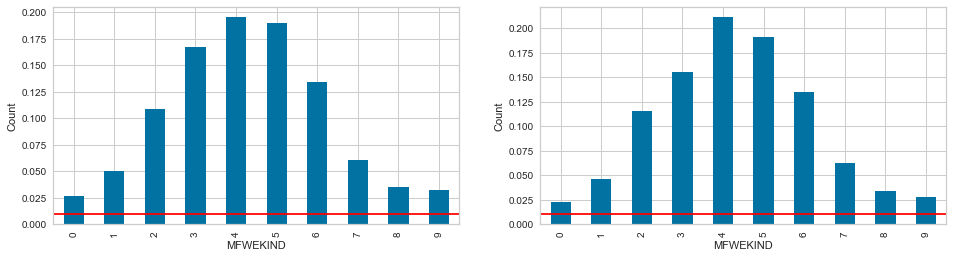

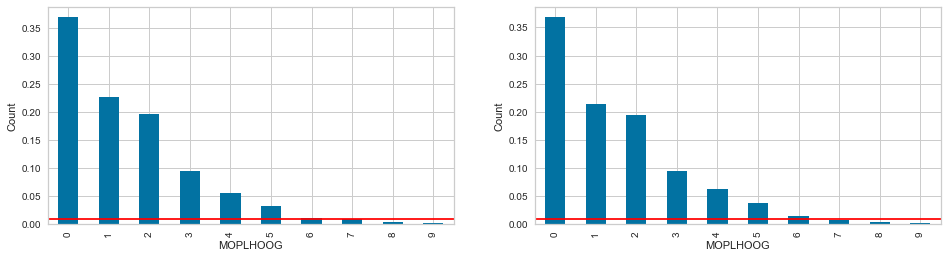

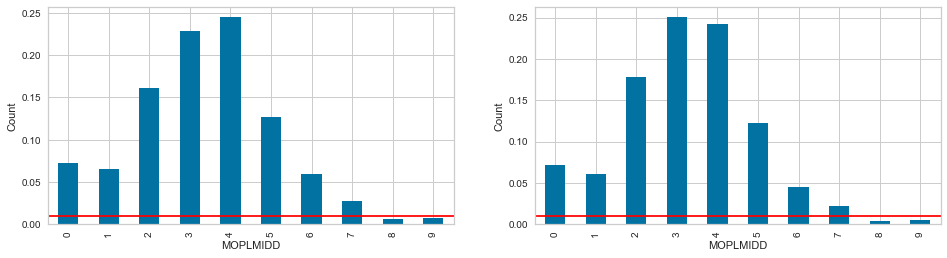

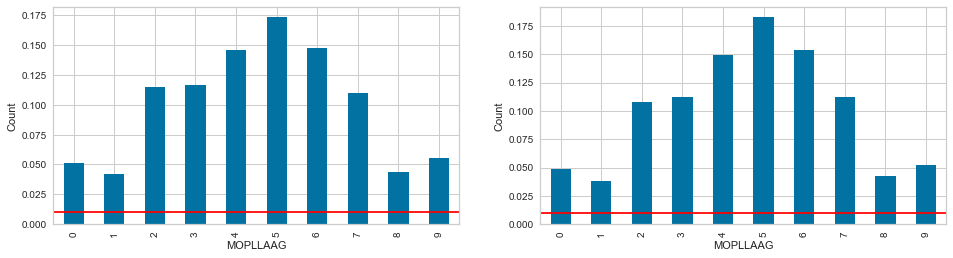

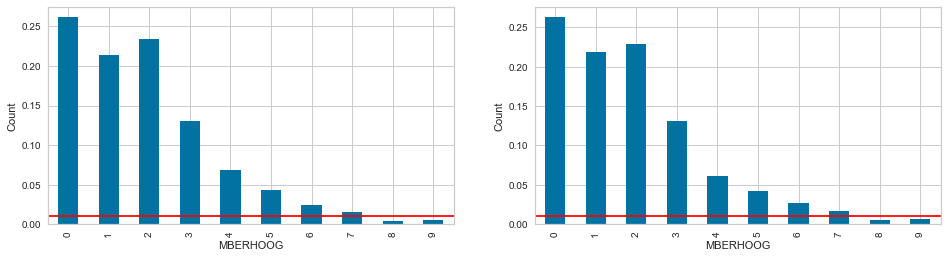

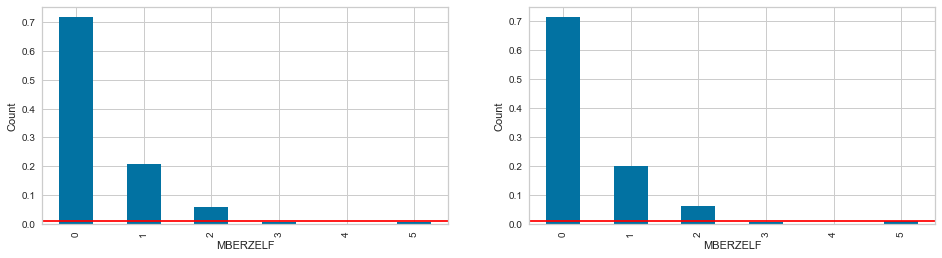

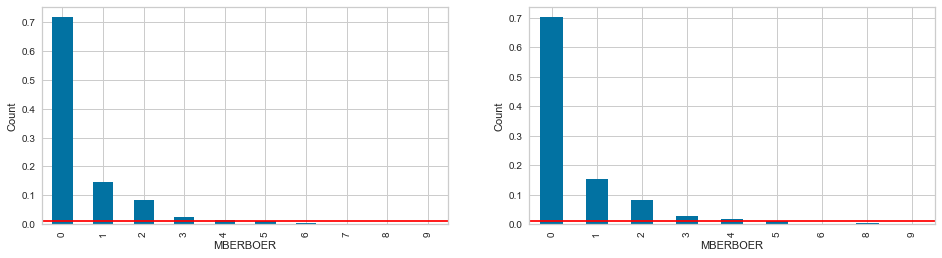

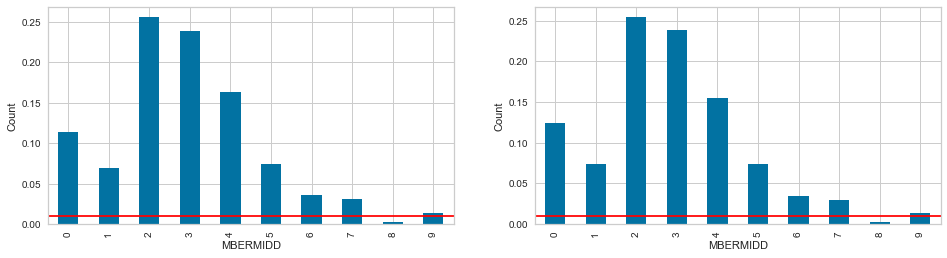

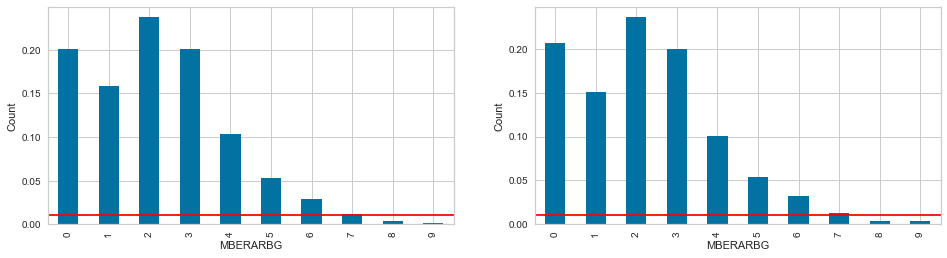

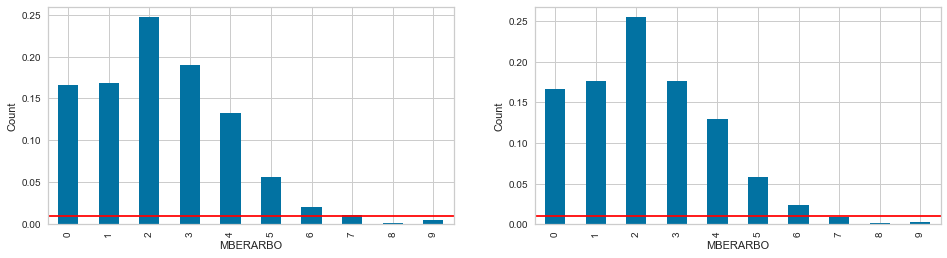

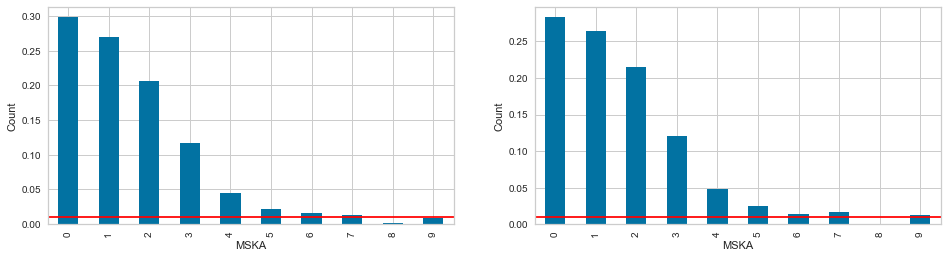

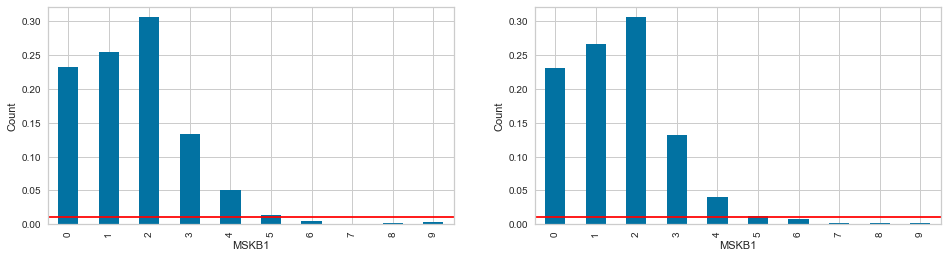

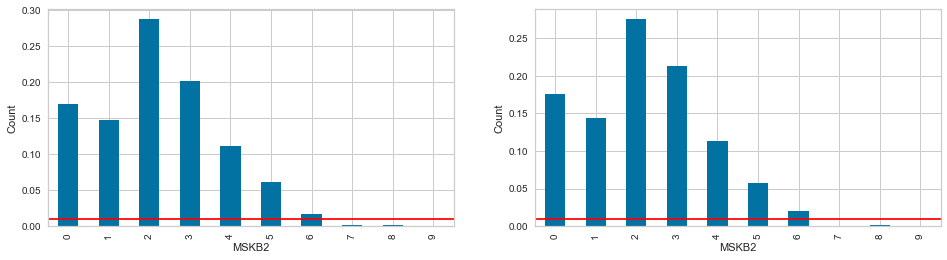

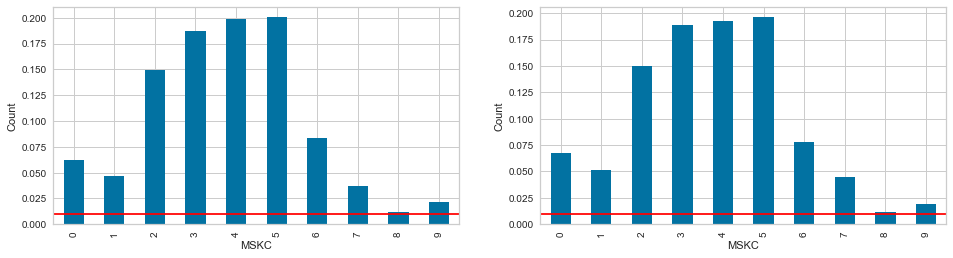

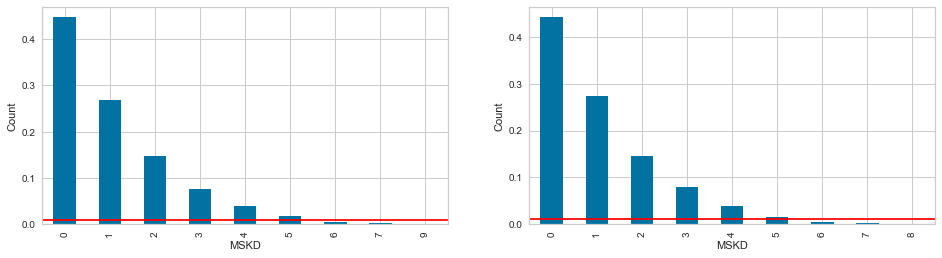

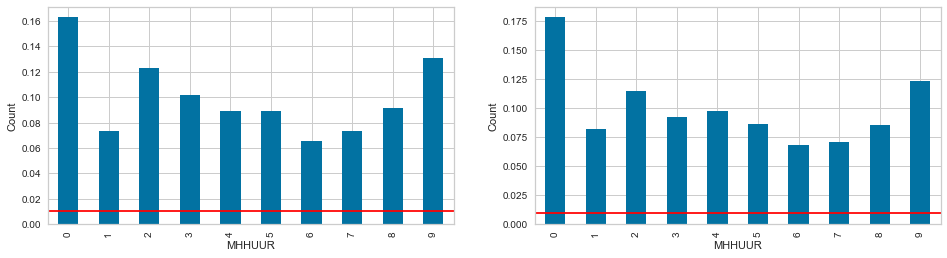

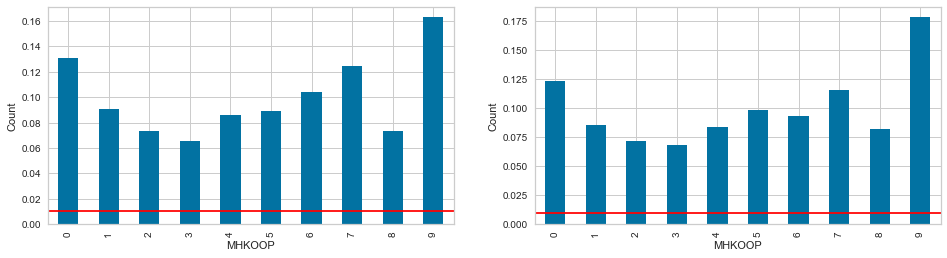

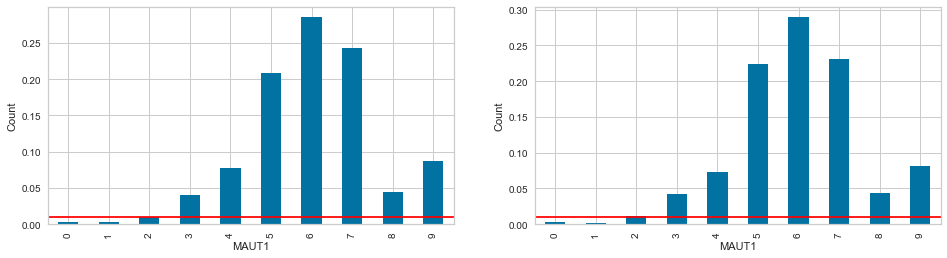

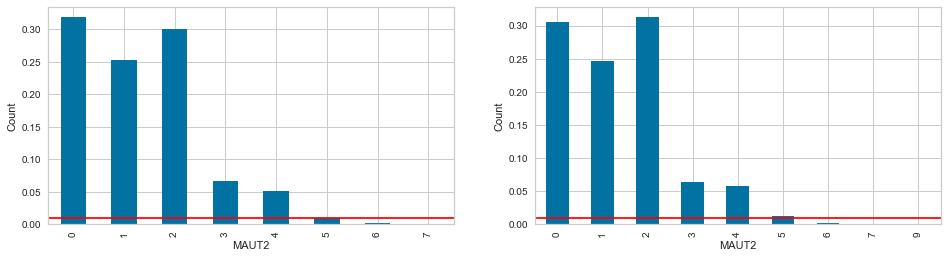

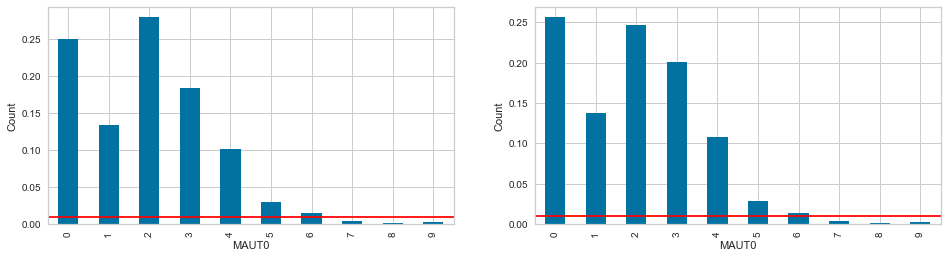

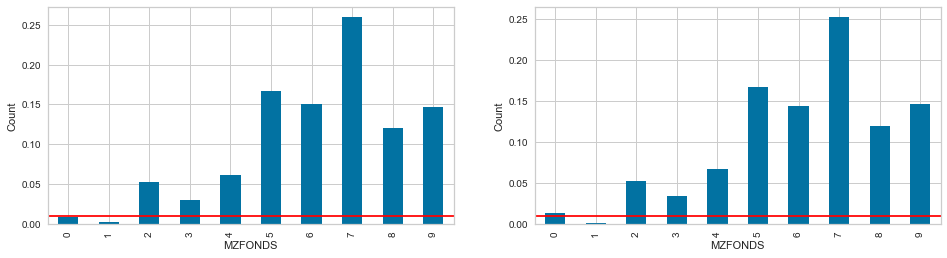

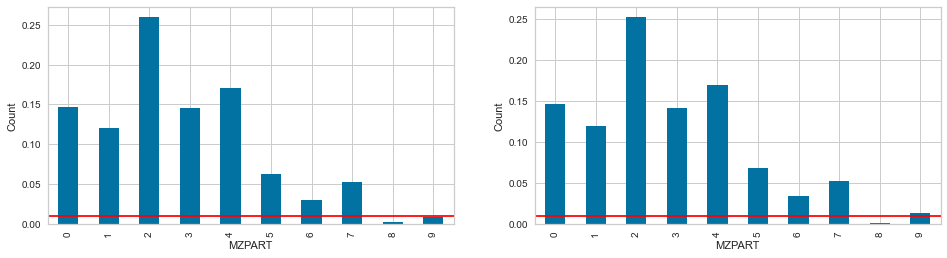

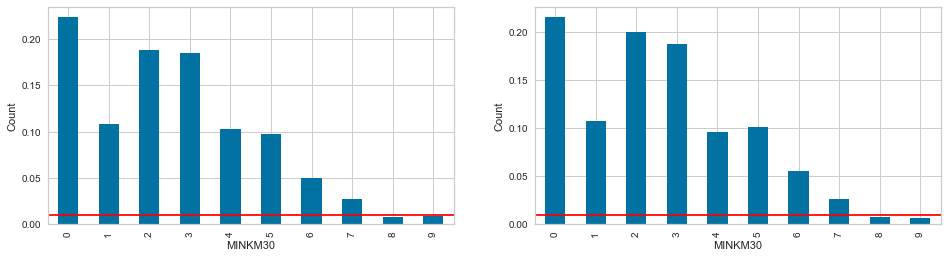

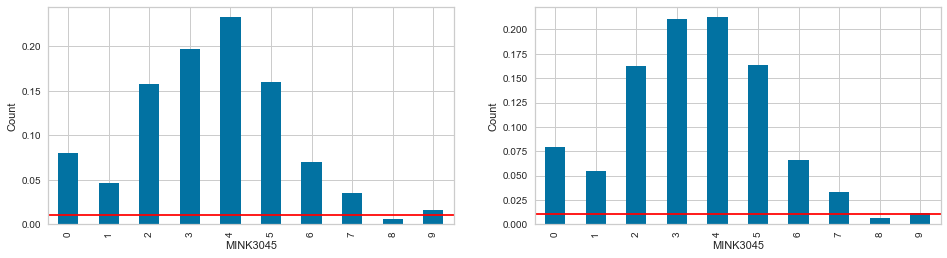

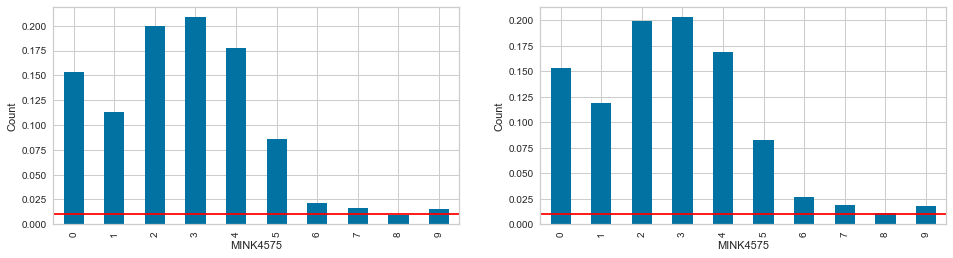

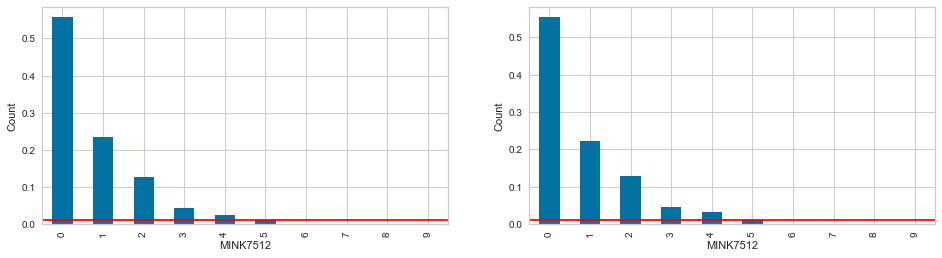

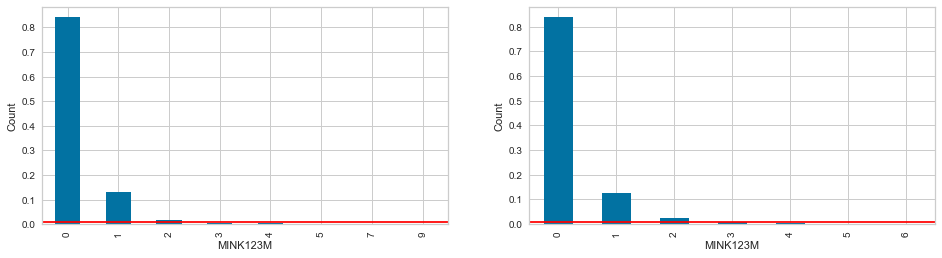

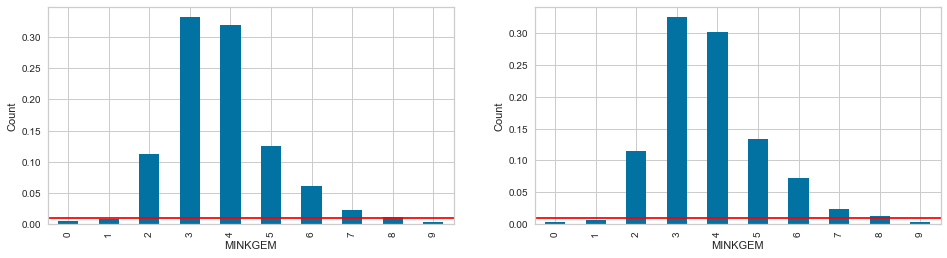

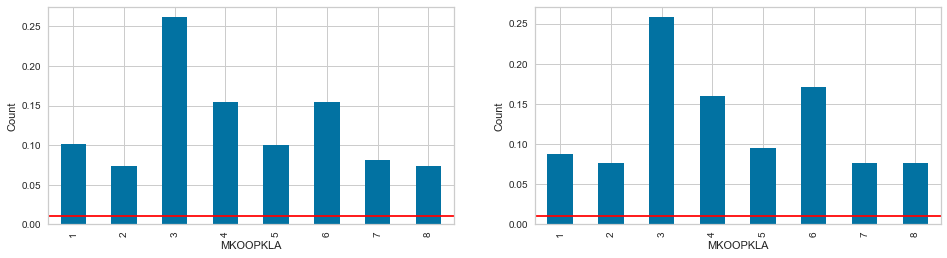

In [7]:
for feature in L3:
    compare_plot(train_df, test_df, feature)

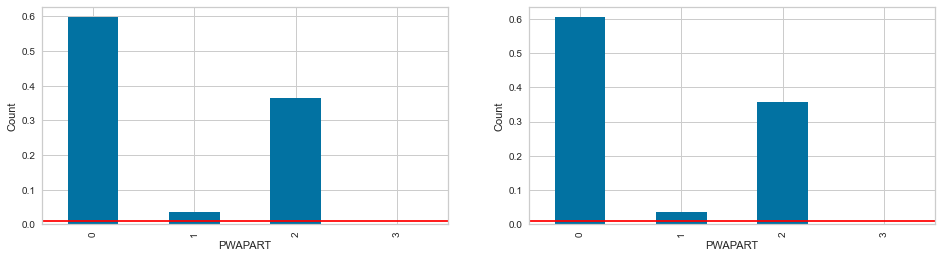

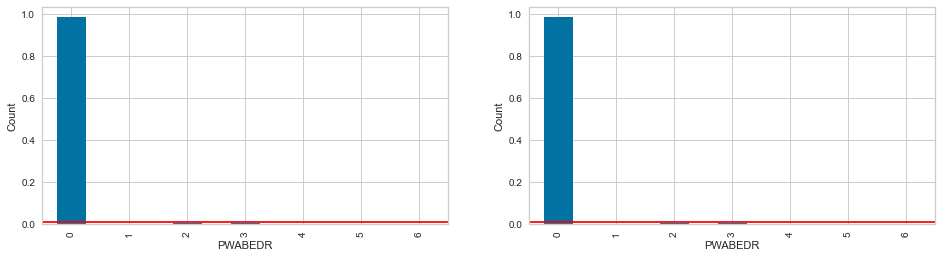

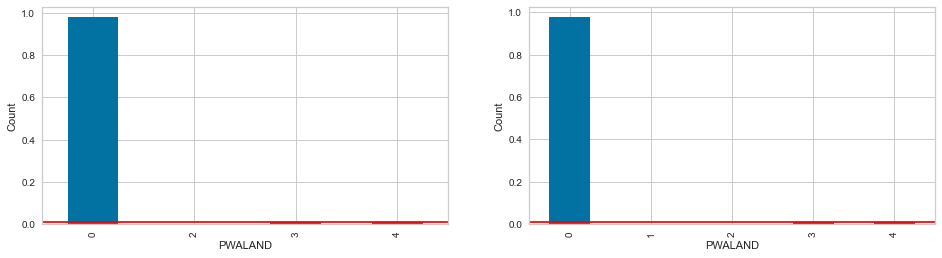

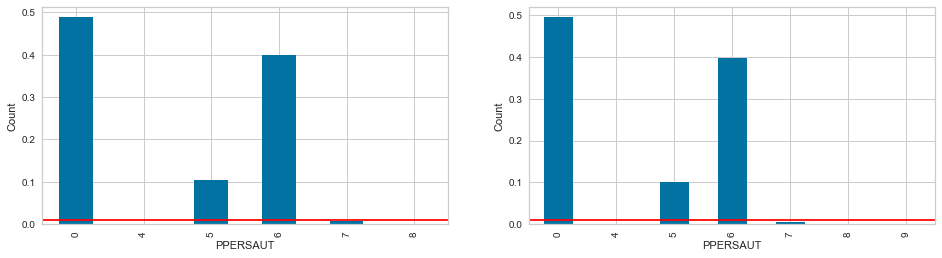

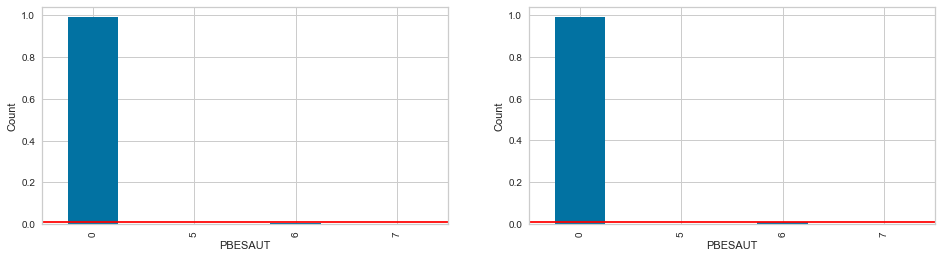

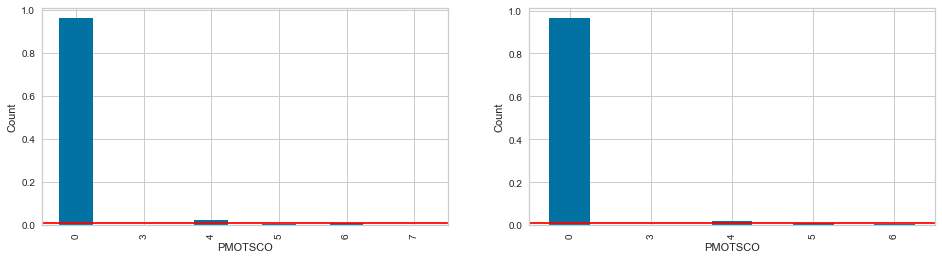

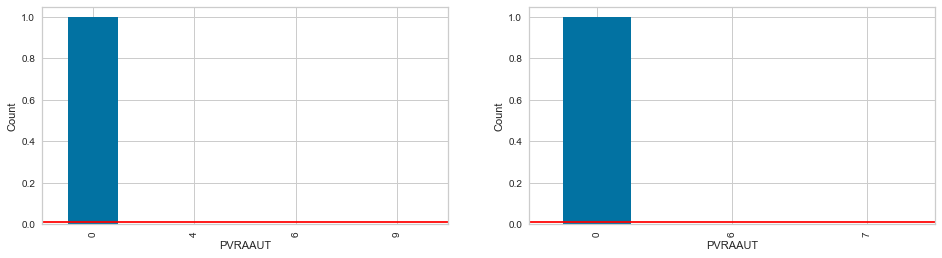

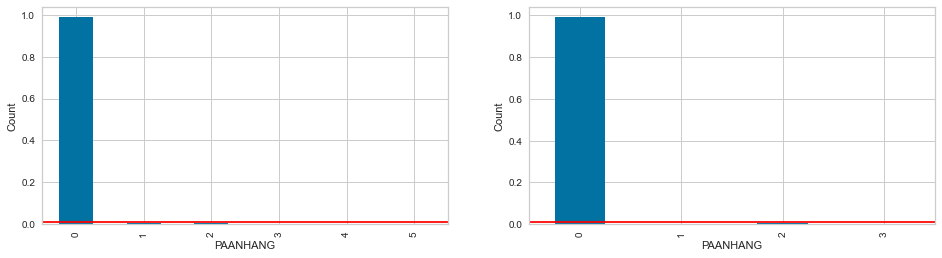

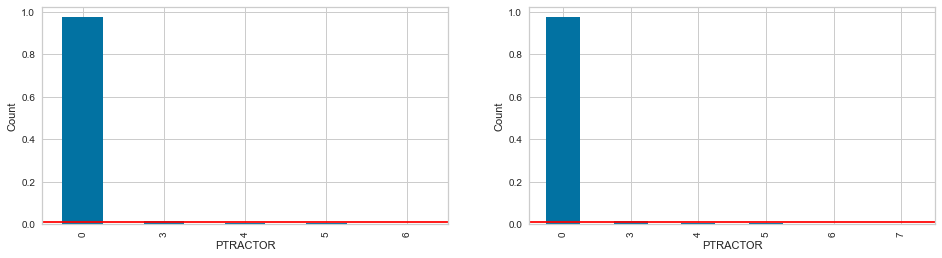

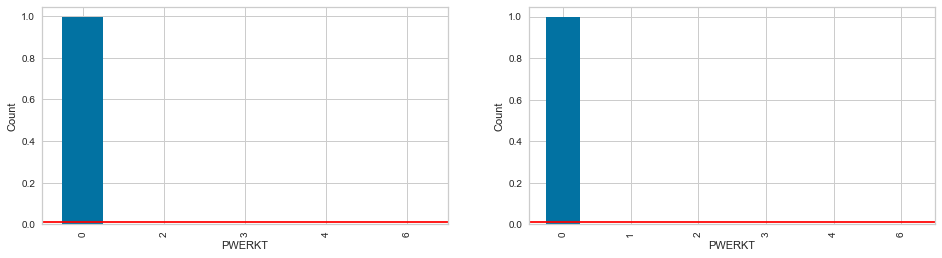

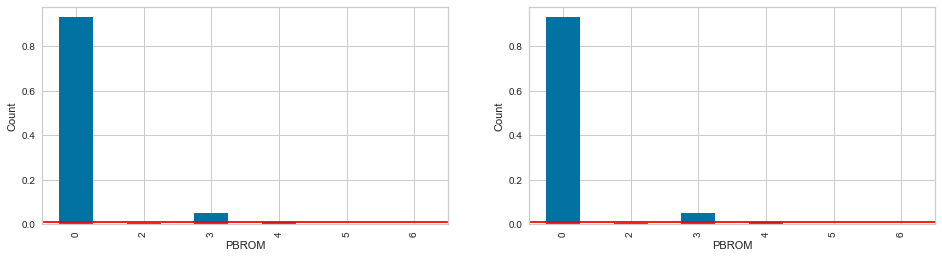

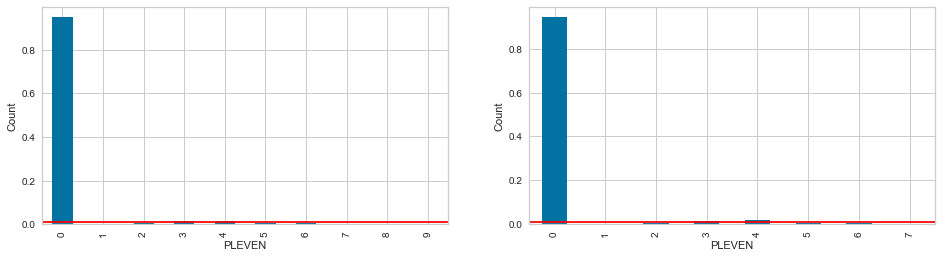

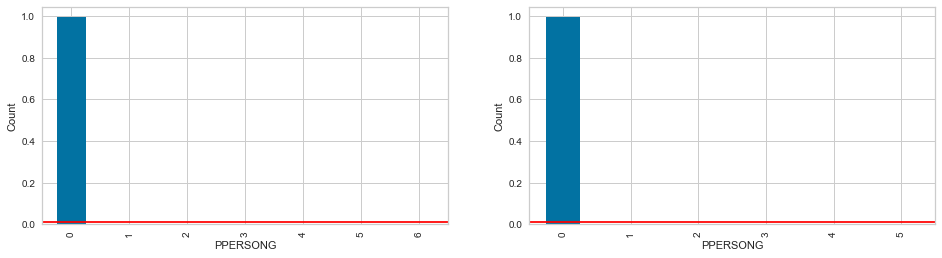

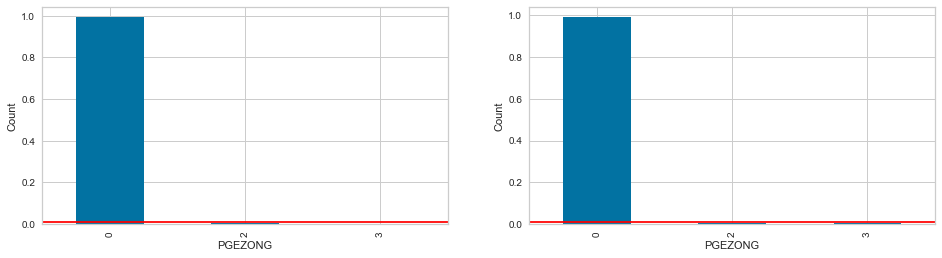

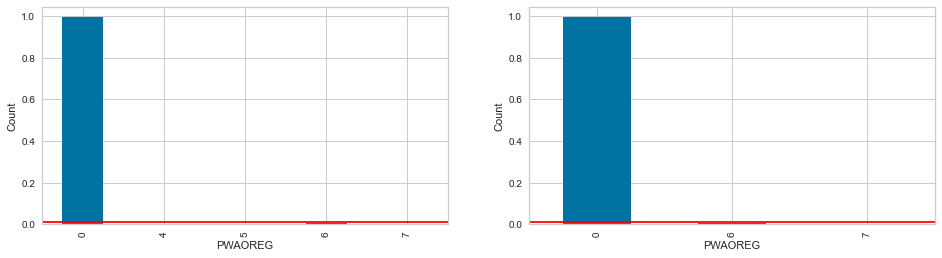

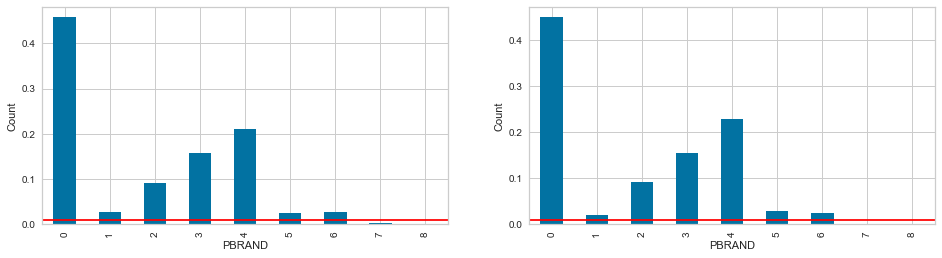

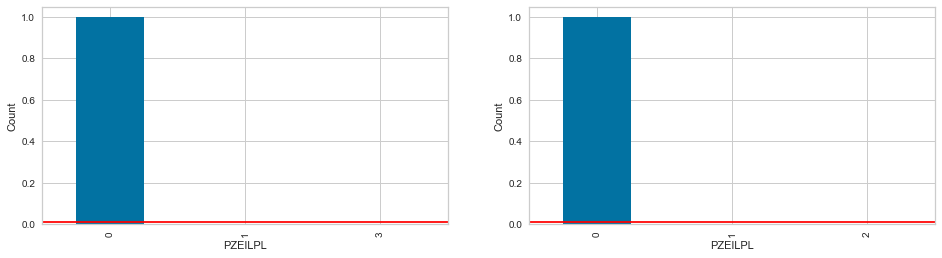

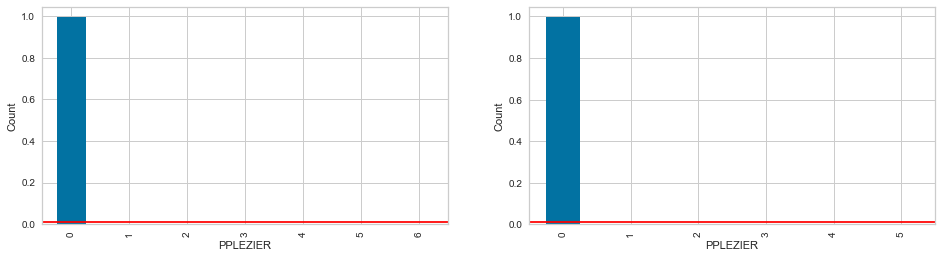

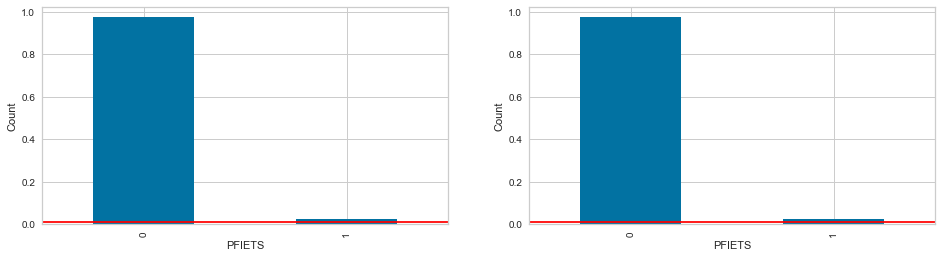

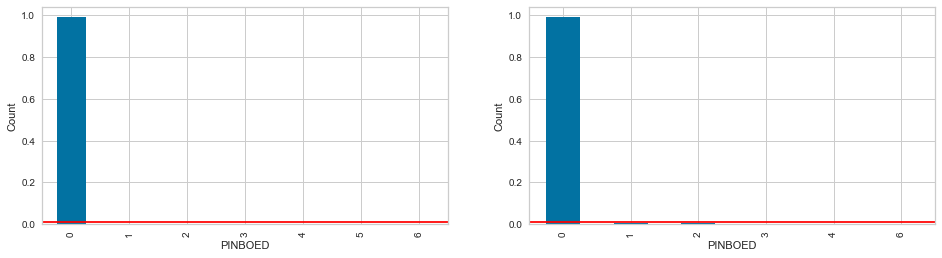

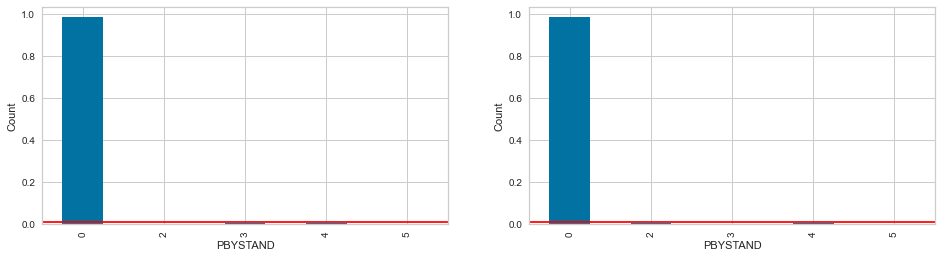

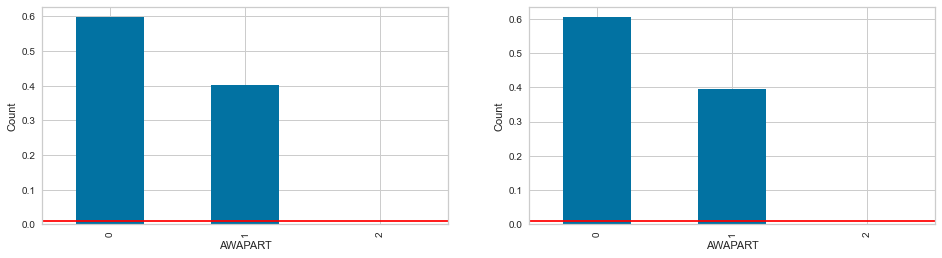

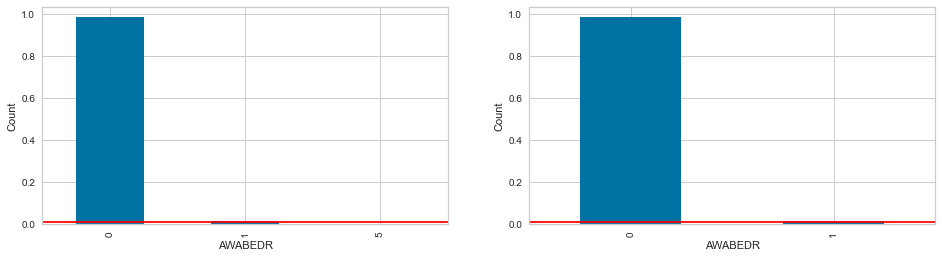

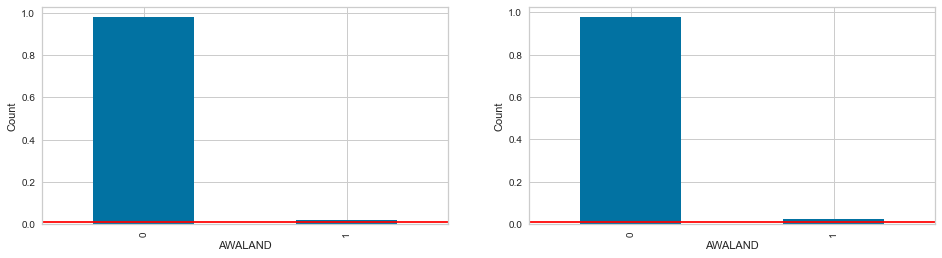

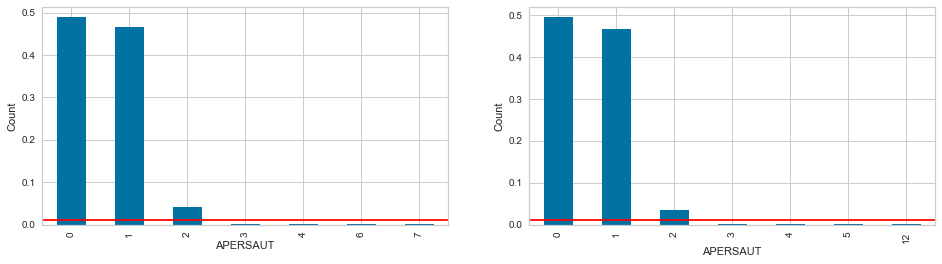

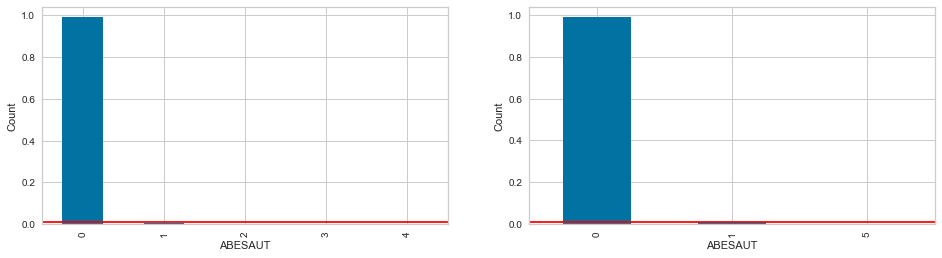

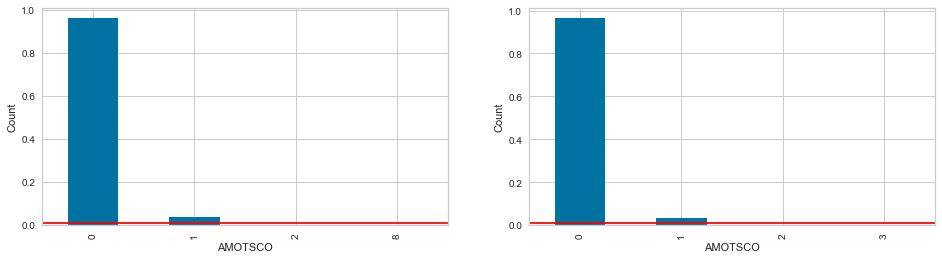

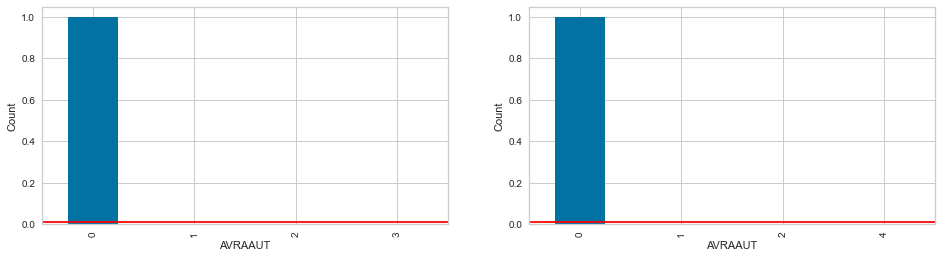

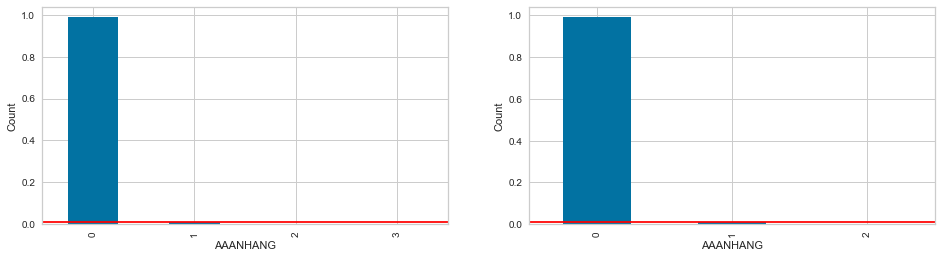

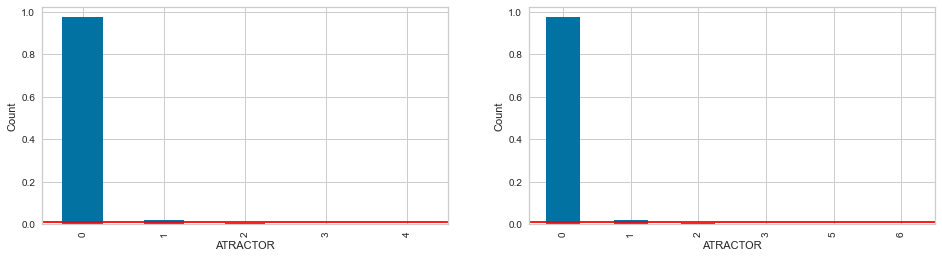

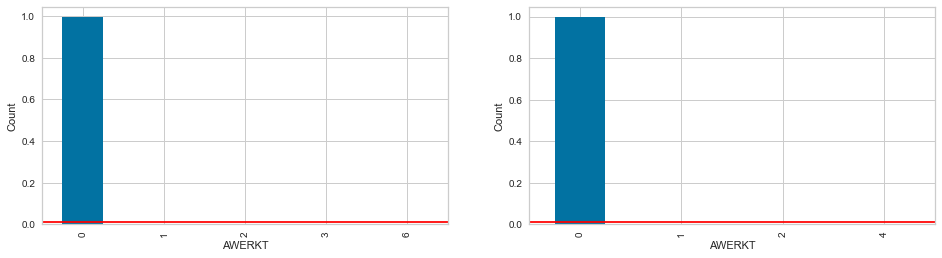

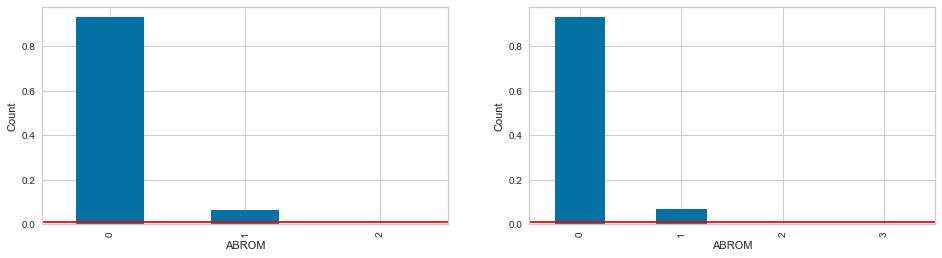

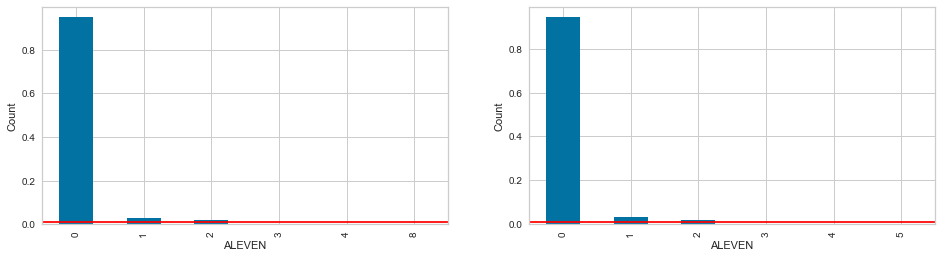

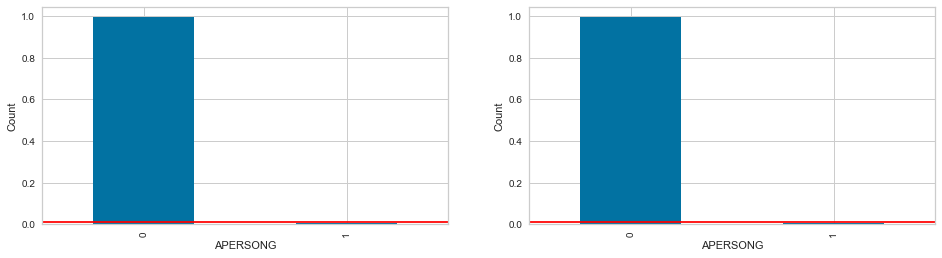

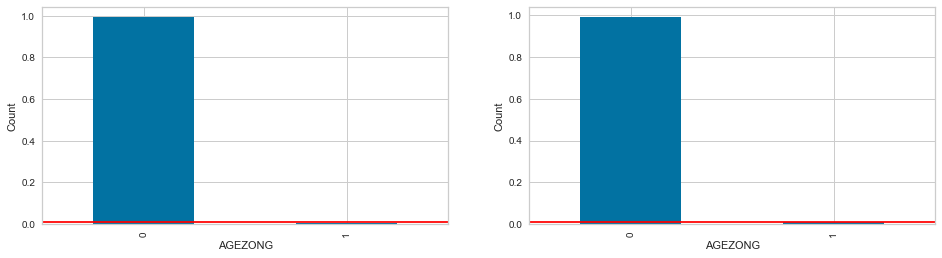

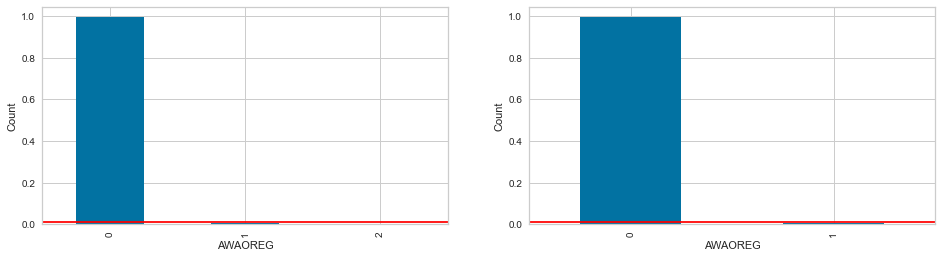

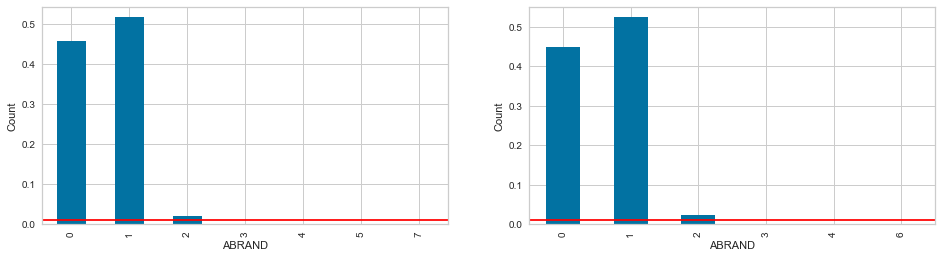

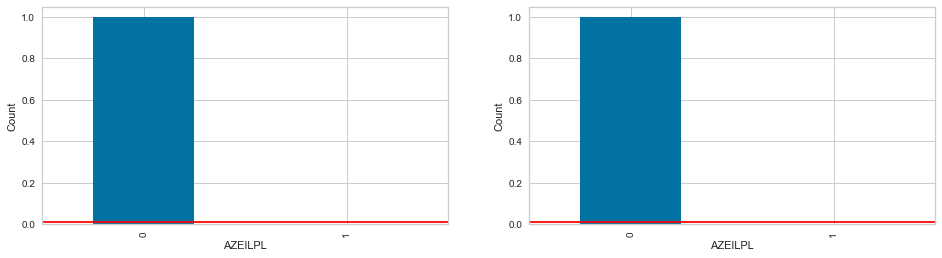

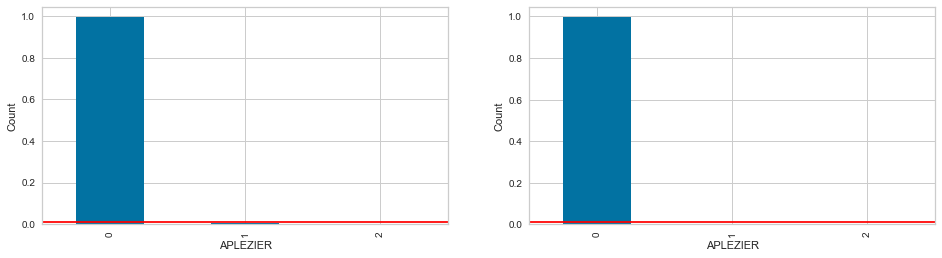

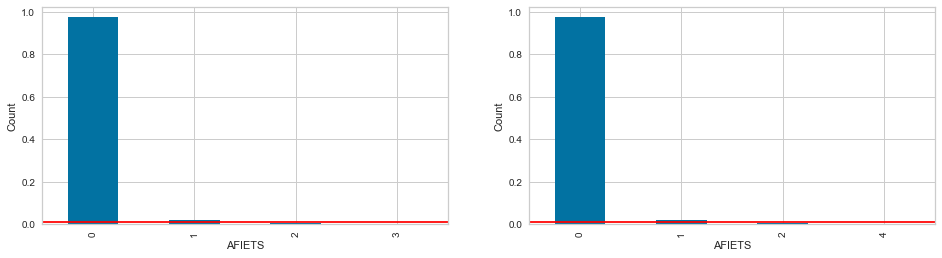

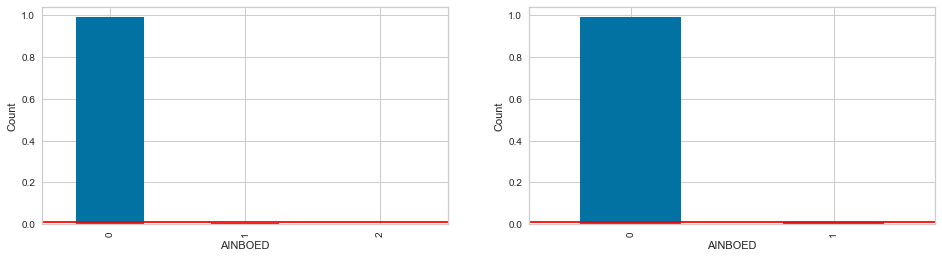

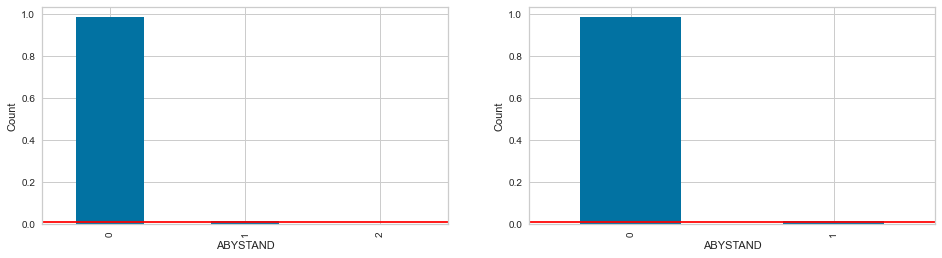

In [8]:
for feature in L4:
    compare_plot(train_df, test_df, feature)

Observations:
* Tree based methods can be sensitive for rare values in categorical features. I made a few experiments where I merged rare values but cannot really obtain the results.
* APERSAUT = 12 is an anomaly, have to correct it.

In [9]:
test_df.loc[test_df['APERSAUT']==12, 'APERSAUT'] = None

In [12]:
test_col = test_df.columns
imputer = KNNImputer(weights='uniform')
test_df = pd.DataFrame(imputer.fit_transform(test_df), columns=test_col)

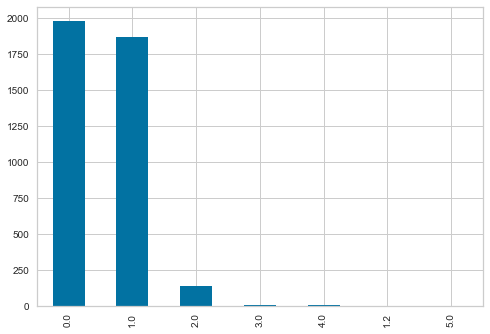

In [13]:
test_df['APERSAUT'].value_counts().plot(kind='bar');

In [14]:
test_df['APERSAUT'] = test_df['APERSAUT'].apply(lambda x: 1.0 if x==1.2 else x)
test_df['APERSAUT'] = test_df['APERSAUT'].apply(int)

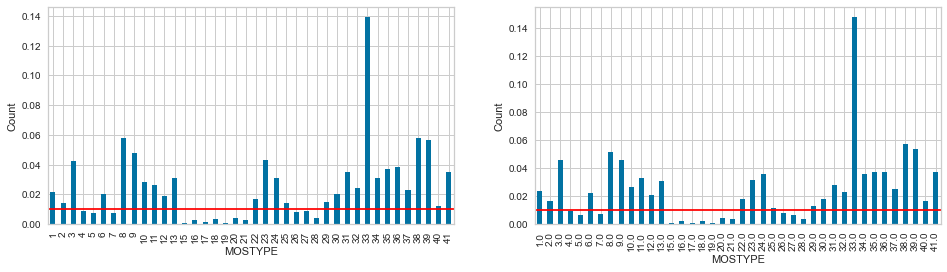

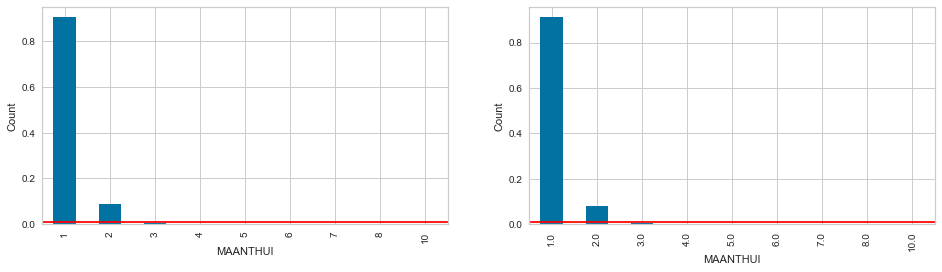

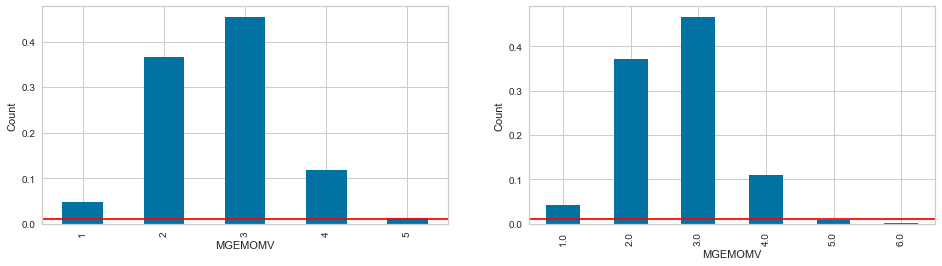

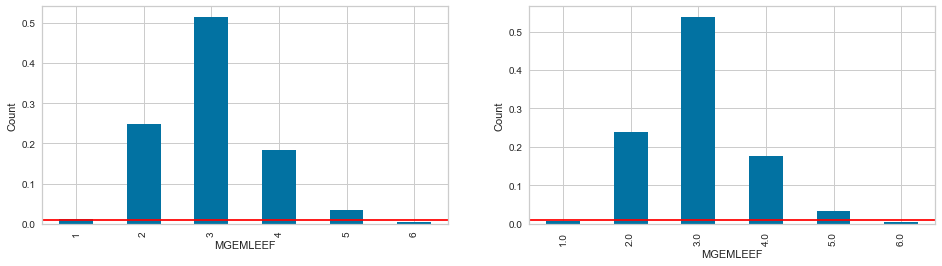

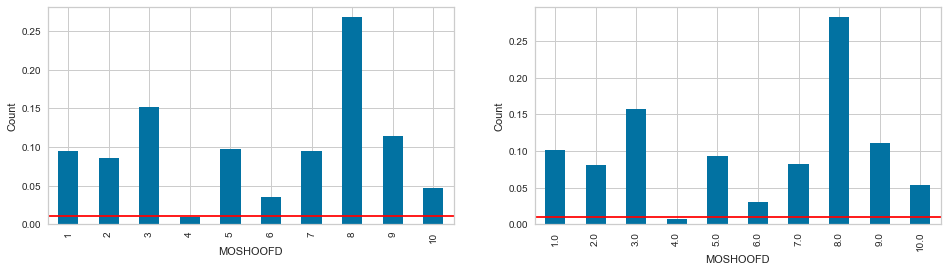

In [15]:
the_rest = ['MOSTYPE', 'MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD']
for feature in the_rest:
    compare_plot(train_df, test_df, feature)

Almost exactly the same distributions.

## Correlations

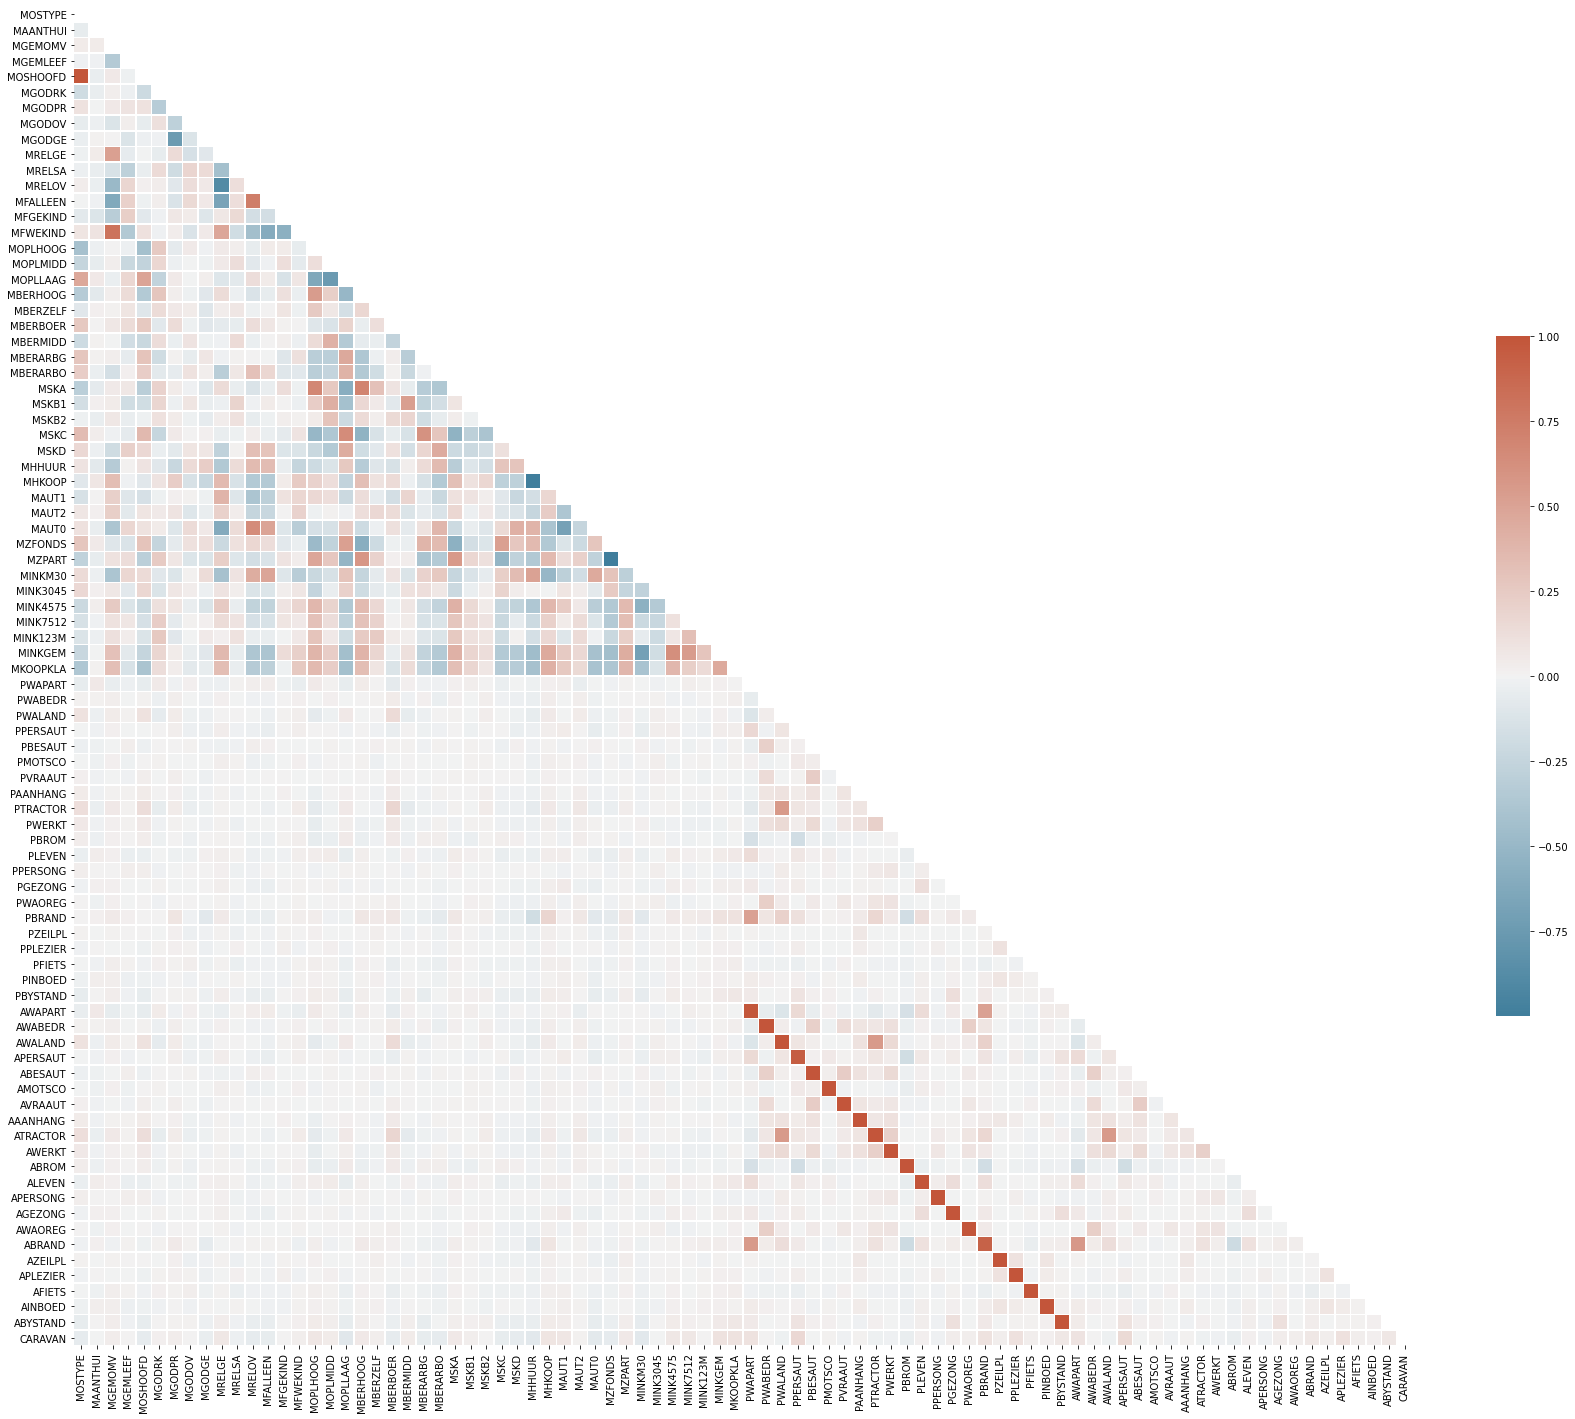

In [33]:
f, ax = plt.subplots(figsize=(30, 25))
mat = train_df.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

* The Customer Main type and Customer Subtype are highly correlated (quite intuitive)
* There's a very interesting block in the lower part. We can literarly make pairs because these are still sociodemographic datas and for example of course in a postal code area the number of third party inssurances and the contributions are highly correlated. All the other pairs make sense. (We can simply read that from the data description but without the correlation probably we won't recognise that.)
* Home owners and Rented houses show highly negative correlation with each other (in a postal code area) which is not so surprising.
* In the case of the L4 features these are rather pairs than blocks. As far as I know correlations won't be so problematic for random forest (specially if they are not in blocks so we have to be very unlucky to select highly correlated features for 'split contribution' -> what I mean by that what the max_features hyperparameter defines in the random forest.
* L3 and the categorical variables seem to be somewhat more interesting. I cannot really see exact patterns but clearly there is a block there.
* The response variable does not show any visible correlation (and I obtained that for myself when I analyzed the distributions of the response variable in each features). We cannot really pick good predictors based on the distributions and the correlation map.

# Feature Engineering

## Enumerations

Based on the data description. This is important because the differences are not appropiate with the original enumerations.

In [16]:
for feature in L3:
    train_df[feature].replace({
        1: (1+10)/2,
        2: (11+23)/2,
        3: (24+36)/2,
        4: (37+49)/2,
        5: (50+62)/2,
        6: (63+75)/2,
        7: (76+88)/2,
        8: (89+99)/2,
        9: 100
    }, inplace=True)
    
    test_df[feature].replace({
        1: (1+10)/2,
        2: (11+23)/2,
        3: (24+36)/2,
        4: (37+49)/2,
        5: (50+62)/2,
        6: (63+75)/2,
        7: (76+88)/2,
        8: (89+99)/2,
        9: 100
    }, inplace=True)

In [17]:
for feature in L4:
    train_df[feature].replace({
        1: (1+49)/2,
        2: (50+99)/2,
        3: (100+199)/2,
        4: (200+499)/2,
        5: (500+999)/2,
        6: (1000+4999)/2,
        7: (5000+9999)/2,
        8: (10000+19999)/2,
        9: 25000
    }, inplace=True)
    
    test_df[feature].replace({
        1: (1+49)/2,
        2: (50+99)/2,
        3: (100+199)/2,
        4: (200+499)/2,
        5: (500+999)/2,
        6: (1000+4999)/2,
        7: (5000+9999)/2,
        8: (10000+19999)/2,
        9: 25000
    }, inplace=True)

In [18]:
train_df['MGEMLEEF'].replace({
    1: 25,
    2: 35,
    3: 45,
    4: 55,
    5: 65,
    6: 75
}, inplace=True)

test_df['MGEMLEEF'].replace({
    1: 25,
    2: 35,
    3: 45,
    4: 55,
    5: 65,
    6: 75
}, inplace=True)

## Highly correlated features

Before the encoding I want to drop one of the highly correlated feature-pairs.

In [19]:
def calcDrop(res):
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))
    poss_drop = list(set(res['drop'].tolist()))
    keep = list(set(all_corr_vars).difference(set(poss_drop)))
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))
    poss_drop = list(set(poss_drop).difference(set(drop)))
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.append(item)         
    return drop

In [20]:
def corrX_new(df, cut) :
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))    
    dropcols = []    
    res = pd.DataFrame(columns=(['v1', 'v2', 'v1.target', 
                                 'v2.target','corr', 'drop' ]))    
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] < avg_corr.iloc[col]): 
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]
                else: 
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]                
                s = pd.Series([ corr_mtx.index[row],
                up.columns[col],
                avg_corr[row],
                avg_corr[col],
                up.iloc[row,col],
                drop],
                index = res.columns)        
                res = res.append(s, ignore_index = True)    
    dropcols_names = calcDrop(res)    
    return(dropcols_names)

I used this during Mathematical Modelling last semester. The pseudo code is the following:<br>
* If a correlation is above the cut threshold between two features the function will append the feature which has higher absolute-correlation with all the other features<br>
* The main point is that after each 'append' the correlations are re-calculated with the feature removed which was appended to the list.

In [21]:
to_be_dropped = corrX_new(train_df, 0.85)
to_be_dropped.remove('MOSTYPE') # i do not want to remove this intuitively seems very important

In [22]:
for feature in to_be_dropped:
    train_df.drop(feature, axis=1, inplace=True)
    test_df.drop(feature, axis=1, inplace=True)

## Encoding

I consider only the Customer subtype and maintype nominal categorical variable.

In [23]:
for_dummies = ['MOSTYPE', 'MOSHOOFD']
train_df = pd.get_dummies(train_df, prefix = for_dummies, columns = for_dummies)
test_df = pd.get_dummies(test_df, prefix = for_dummies, columns = for_dummies)

## Permutation importance

In [16]:
"""train_df = train_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)
train_df.to_csv("train_df_prep.csv", index=False)
train_df = pd.read_csv('train_df_prep.csv')"""

In [24]:
X_train = train_df.drop(['CARAVAN'], axis=1)
y_train = train_df['CARAVAN']

In [25]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1)

In [26]:
def search_results_optuna(study):
    unnecessary = ['number', 'datetime_start', 'datetime_complete', 'duration', 'state']
    results = study.trials_dataframe()
    for col in unnecessary:
        results.drop([col], axis=1, inplace=True)
    results.sort_values(by='value', ascending=False, inplace=True)
    return results

In [27]:
def evaluation(y_pred, y_true):
    return ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_val, cmap='Blues'), print(classification_report(y_pred=y_pred, y_true=y_val))

In [54]:
""""cat_indx = []
for i in range(49):
    cat_indx.append(i)"""

I made quite a few experiments with SMOTE, but surprisingly cannot outperform the over sampling approach.

In [28]:
def rf_smote_objective(trial):
    model = imbalanced_make_pipeline(
        RandomOverSampler(
            random_state=1
        ),
        RandomForestClassifier(
            min_samples_split = trial.suggest_float('min_samples_split', 2/X_t.shape[0], 0.01),
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']),
            max_features = trial.suggest_int('max_features', 3, 12),
            n_estimators = trial.suggest_int('n_estimators', 70, 200),
            min_samples_leaf = trial.suggest_float('min_samples_leaf', 1/X_t.shape[0], 0.01),
            random_state=1,
            bootstrap = trial.suggest_categorical('bootstrap', [True, False])
        )
    )
    score = cross_val_score(model, X_t, y_t, scoring='balanced_accuracy', cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True))
    bal_acc_mean = score.mean()
    return bal_acc_mean

rf_smote_study = optuna.create_study(
    direction="maximize"
)

rf_smote_study.optimize(rf_smote_objective, n_trials=6)

[I 2022-08-08 23:16:56,346] A new study created in memory with name: no-name-1156d1e5-bdad-4fb6-92a4-b99951652c3f
[I 2022-08-08 23:17:00,346] Trial 0 finished with value: 0.6614759785742008 and parameters: {'min_samples_split': 0.009677246662819699, 'criterion': 'gini', 'max_features': 8, 'n_estimators': 95, 'min_samples_leaf': 0.008964456790500758, 'bootstrap': False}. Best is trial 0 with value: 0.6614759785742008.
[I 2022-08-08 23:17:02,947] Trial 1 finished with value: 0.6647196311769769 and parameters: {'min_samples_split': 0.0016657289109547613, 'criterion': 'gini', 'max_features': 8, 'n_estimators': 74, 'min_samples_leaf': 0.0063955964797227675, 'bootstrap': True}. Best is trial 1 with value: 0.6647196311769769.
[I 2022-08-08 23:17:07,663] Trial 2 finished with value: 0.6169809957714868 and parameters: {'min_samples_split': 0.005972209024668613, 'criterion': 'gini', 'max_features': 4, 'n_estimators': 134, 'min_samples_leaf': 0.0014881133638161368, 'bootstrap': False}. Best is tr

              precision    recall  f1-score   support

           0       0.98      0.78      0.87       548
           1       0.17      0.69      0.27        35

    accuracy                           0.78       583
   macro avg       0.57      0.74      0.57       583
weighted avg       0.93      0.78      0.83       583

Train balanced acc.:  0.7978853809544193
Test balanced acc.:  0.7351929092805005


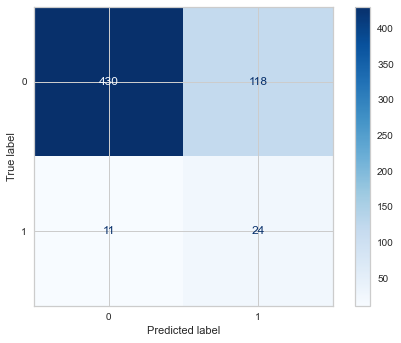

In [29]:
randomoversampler = RandomOverSampler(random_state=1)
randomforestclassifier = RandomForestClassifier(
    random_state=1,
    min_samples_split=rf_smote_study.best_params['min_samples_split'],
    criterion=rf_smote_study.best_params['criterion'],
    max_features=rf_smote_study.best_params['max_features'],
    n_estimators=rf_smote_study.best_params['n_estimators'],
    min_samples_leaf=rf_smote_study.best_params['min_samples_leaf'],
    bootstrap=rf_smote_study.best_params['bootstrap']
)
pipe_rf_rus = imbalanced_make_pipeline(randomoversampler, randomforestclassifier)
pipe_rf_rus.fit(X_t.values, y_t)
y_pred = pipe_rf_rus.predict(X_val.values)
evaluation(y_pred, y_val)
X_train_preds = pipe_rf_rus.predict_proba(X_t.values)[:,1]
X_train_pred_score = pipe_rf_rus.predict(X_t.values)
X_val_preds = pipe_rf_rus.predict_proba(X_val.values)[:,1]
print('Train balanced acc.: ', balanced_accuracy_score(y_t, X_train_pred_score))
print('Test balanced acc.: ', balanced_accuracy_score(y_val, y_pred))

In [30]:
Xros_train, yros_train = randomoversampler.fit_resample(X_t, y_t)

In [31]:
permutation_results = permutation_importance(
    pipe_rf_rus.steps[1][1], Xros_train, yros_train, scoring='balanced_accuracy', random_state=1, n_jobs=-1, n_repeats=5
)

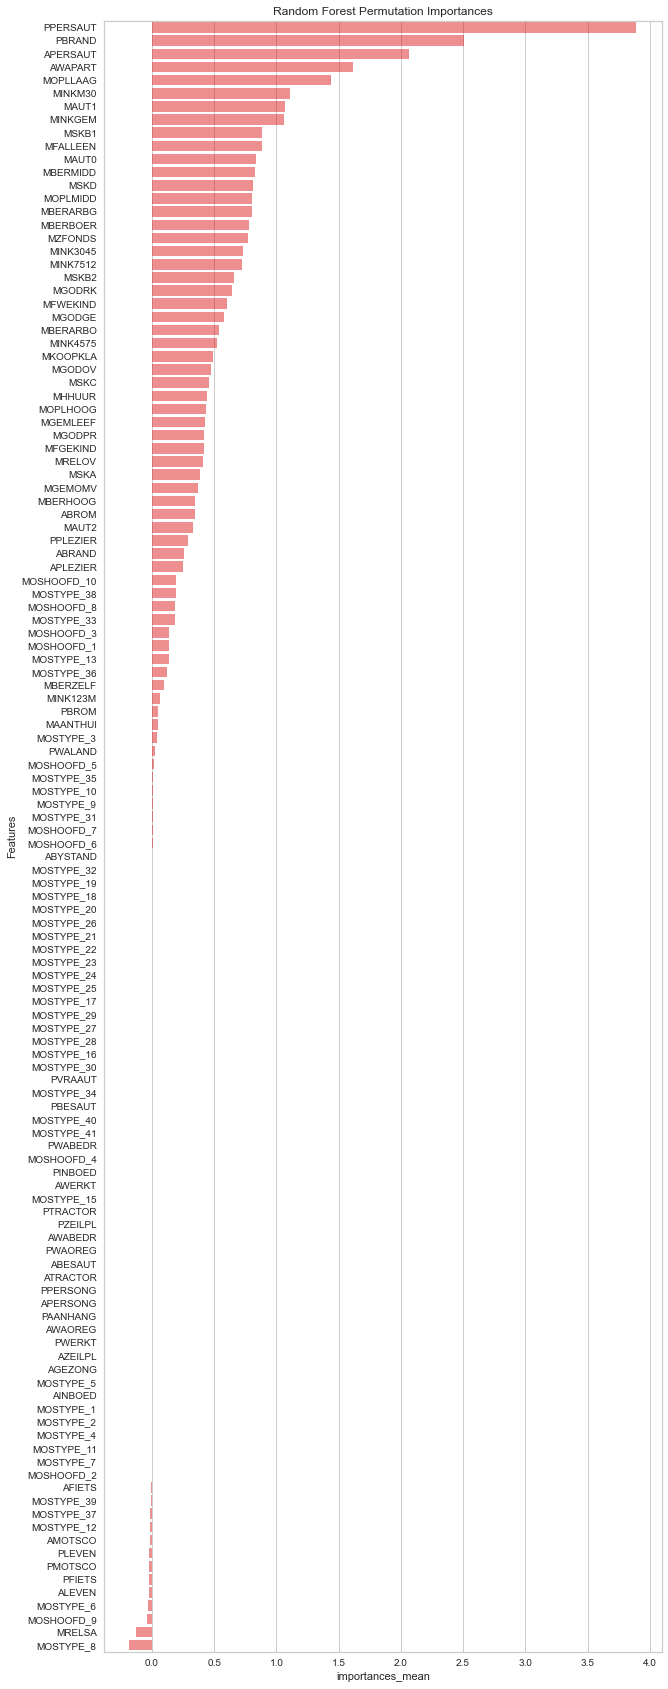

In [32]:
permutation_results_df = pd.DataFrame({'importances_mean': permutation_results.importances_mean*100, 'Features': X_t.columns})
plt.figure(figsize=(10,30))
sns.barplot(x='importances_mean', y='Features', data=permutation_results_df.sort_values(by ='importances_mean', ascending=False), color='red', alpha=0.5).set_title('Random Forest Permutation Importances')
plt.show()

In [33]:
sel = permutation_results_df[permutation_results_df['importances_mean']>0]['Features'].to_list()

In [35]:
X_t = X_t[sel]
X_val = X_val[sel]

# Classification

In [36]:
def rf_smote_objective(trial):
    model = imbalanced_make_pipeline(
        randomoversampler,
        RandomForestClassifier(
            min_samples_split = trial.suggest_float('min_samples_split', 2/X_t.shape[0], 0.01),
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']),
            max_features = trial.suggest_int('max_features', 3, 12),
            n_estimators = trial.suggest_int('n_estimators', 70, 200),
            min_samples_leaf = trial.suggest_float('min_samples_leaf', 1/X_t.shape[0], 0.01),
            random_state=1,
            bootstrap = trial.suggest_categorical('bootstrap', [True, False])
        )
    )
    score = cross_val_score(model, X_t, y_t, scoring='balanced_accuracy', cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True))
    bal_acc_mean = score.mean()
    return bal_acc_mean

rf_smote_study = optuna.create_study(
    direction="maximize"
)

rf_smote_study.optimize(rf_smote_objective, n_trials=8)

[I 2022-08-08 23:21:59,339] A new study created in memory with name: no-name-753d60e9-73d6-4490-ae8f-b4d9cb2ed126
[I 2022-08-08 23:22:03,564] Trial 0 finished with value: 0.6596979243374246 and parameters: {'min_samples_split': 0.002211518847103382, 'criterion': 'entropy', 'max_features': 7, 'n_estimators': 89, 'min_samples_leaf': 0.006624032502384354, 'bootstrap': False}. Best is trial 0 with value: 0.6596979243374246.
[I 2022-08-08 23:22:07,313] Trial 1 finished with value: 0.6614687449732062 and parameters: {'min_samples_split': 0.009632917314634103, 'criterion': 'gini', 'max_features': 12, 'n_estimators': 73, 'min_samples_leaf': 0.004819189587819836, 'bootstrap': True}. Best is trial 1 with value: 0.6614687449732062.
[I 2022-08-08 23:22:12,361] Trial 2 finished with value: 0.642806796983675 and parameters: {'min_samples_split': 0.0024448816145950605, 'criterion': 'entropy', 'max_features': 8, 'n_estimators': 90, 'min_samples_leaf': 0.005600941035534984, 'bootstrap': False}. Best is

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       548
           1       0.14      0.60      0.23        35

    accuracy                           0.76       583
   macro avg       0.56      0.69      0.55       583
weighted avg       0.92      0.76      0.82       583

Train balanced acc.:  0.7742184976631786
Test balanced acc.:  0.685948905109489


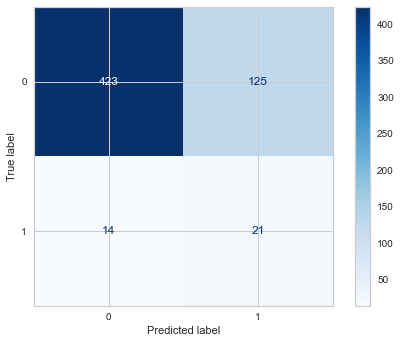

In [37]:
randomforestclassifier = RandomForestClassifier(
    random_state=1,
    min_samples_split=rf_smote_study.best_params['min_samples_split'],
    criterion=rf_smote_study.best_params['criterion'],
    max_features=rf_smote_study.best_params['max_features'],
    n_estimators=rf_smote_study.best_params['n_estimators'],
    min_samples_leaf=rf_smote_study.best_params['min_samples_leaf'],
    bootstrap=rf_smote_study.best_params['bootstrap']
)
pipe_rf_rus = imbalanced_make_pipeline(randomoversampler, randomforestclassifier)
pipe_rf_rus.fit(X_t.values, y_t)
y_pred = pipe_rf_rus.predict(X_val.values)
evaluation(y_pred, y_val)
X_train_preds = pipe_rf_rus.predict_proba(X_t.values)[:,1]
X_train_pred_score = pipe_rf_rus.predict(X_t.values)
X_val_preds = pipe_rf_rus.predict_proba(X_val.values)[:,1]
print('Train balanced acc.: ', balanced_accuracy_score(y_t, X_train_pred_score))
print('Test balanced acc.: ', balanced_accuracy_score(y_val, y_pred))

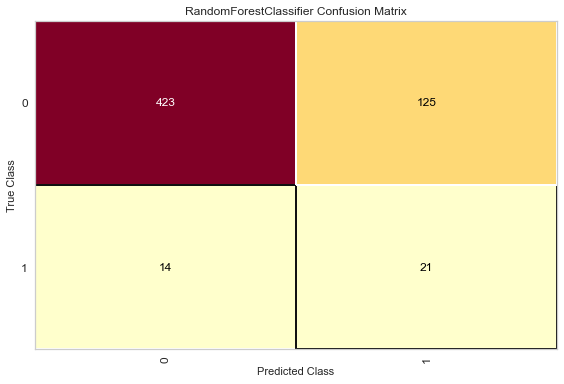

In [42]:
insurance_cm = ConfusionMatrix(
    pipe_rf_rus, classes=[0,1]
)

insurance_cm.fit(X_t, y_t)
insurance_cm.score(X_val, y_val)
insurance_cm.show();

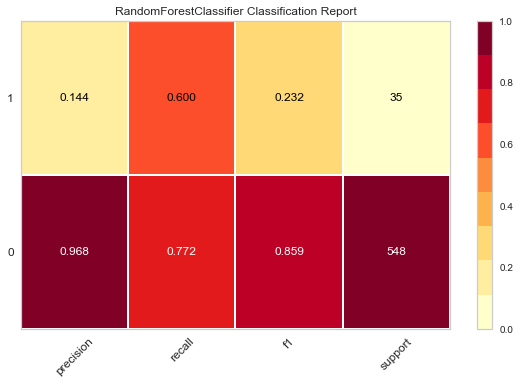

In [44]:
visualizer = ClassificationReport(pipe_rf_rus, classes=[0,1], support=True)

visualizer.fit(X_t, y_t)        # Fit the visualizer and the model
visualizer.score(X_val, y_val)        # Evaluate the model on the test data
visualizer.show();               # Finalize and show the figure

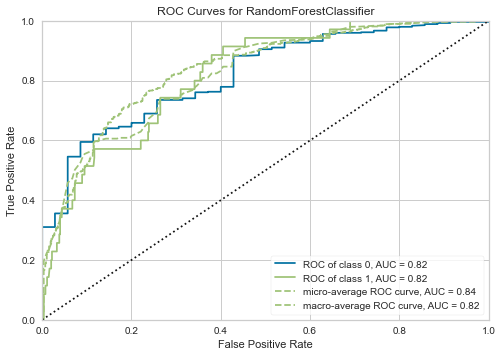

In [45]:
visualizer = ROCAUC(pipe_rf_rus, classes=[0, 1])

visualizer.fit(X_t, y_t)        # Fit the training data to the visualizer
visualizer.score(X_val, y_val)        # Evaluate the model on the test data
visualizer.show();                       # Finalize and show the figure

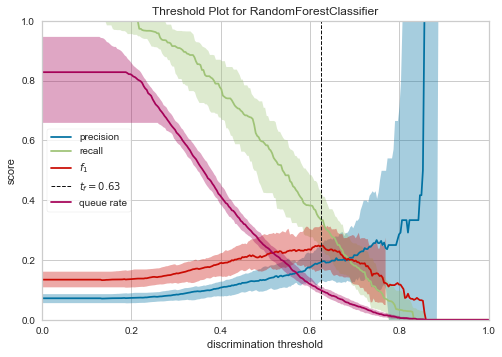

<AxesSubplot:title={'center':'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [46]:
visualizer = DiscriminationThreshold(pipe_rf_rus)

visualizer.fit(X_t, y_t)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       548
           1       0.25      0.51      0.33        35

    accuracy                           0.88       583
   macro avg       0.61      0.71      0.63       583
weighted avg       0.92      0.88      0.90       583

Train balanced acc.:  0.7742184976631786
Validation balanced acc.:  0.7069603753910323


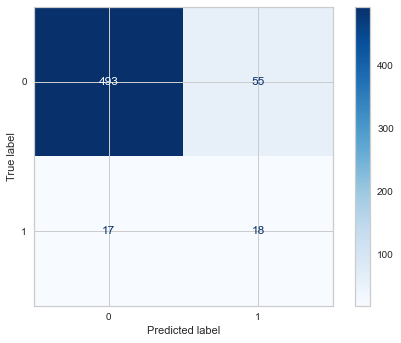

In [52]:
y1_pred = pipe_rf_rus.classes_[1*(X_val_preds>0.63)]
evaluation(y1_pred, y_val)
print('Train balanced acc.: ', balanced_accuracy_score(y_t, X_train_pred_score))
print('Validation balanced acc.: ', balanced_accuracy_score(y_val, y1_pred))

Balanced accuracy is improved.